In [116]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle
import json
from tqdm import tqdm
import os, subprocess
import h5py
import random
import collections
import time

In [117]:
from importlib import reload

In [118]:
import pandas as pd
from scipy.stats import pearsonr

In [119]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [120]:
import rsatoolbox

In [121]:
np.random.seed(7)
torch.manual_seed(7)
random.seed(7)

In [122]:
from domainbed import hparams_registry
from domainbed import algorithms
from domainbed.lib import misc

In [123]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [124]:
import utils
import metrics

In [125]:
# SceneCOCO, ColorObject
# args = utils.load_param("ColorObject")
args = utils.load_param("SceneCOCO")

# calc test acc

In [33]:
#  read stuff
_path = f'saved_dict_{args.dataset}.pkl'
with open(_path, 'rb') as f:
    saved_dict = pickle.load(f)
    print(f"loaded {_path}")

loaded saved_dict_ColorObject_Final.pkl


In [12]:
eval_names = ['test_id_0', 'test_id_1',
              'test_ood1_0.0', 'test_ood1_0.15', 'test_ood1_0.3',
              'test_ood1_0.45', 'test_ood1_0.6',
              'test_ood2_level1', 'test_ood2_level2', 'test_ood2_level3',
              'test_ood2_level4', 'test_ood2_level5']

In [ ]:
## all baselines - ColorObject & SceneObject
args.use_two_labels = False
args.use_mask = False
seed_list = [0, 7, 77, 8, 88,
            1, 777, 7777, 888, 8888]

for _algo in ["ERM", "IRM", "VREx", "GroupDRO", "Fish", "MLDG"]:
    for _seed in seed_list:
        args.algorithm = _algo
        args.trial_seed = _seed
        _exp_name=f"{args.bias}_{args.algorithm}_seed{args.trial_seed}"
        args.exp_name = _exp_name
        saved_dict = utils.run_test(args, eval_names, saved_dict)

In [ ]:
## augmentation - fgRandom+bgOnly - 3 weights mixed
args.aug_fg = True
args.aug_bg = True
args.use_two_labels = True
args.use_mask = True
args.algorithm = "ERM_augmentation"

seed_list = [0, 7, 77, 8, 88,
            1, 777, 7777, 888, 8888]
mix_rate_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for _mix_rate_fg in mix_rate_list:
    _mix_rate_bg = 0.5 - mix_rate_list
    for _seed in seed_list:
        args.trial_seed = _seed
        
        _exp_name = f"{args.bias}_ERM_augmentation_fgRandom{_mix_rate_fg}_bgOnly{_mix_rate_bg}_seed{args.trial_seed}"
        args.exp_name = _exp_name
        saved_dict = utils.run_test(args, eval_names, saved_dict)

In [23]:
len(saved_dict)

221

In [15]:
# save stuff
with open(f'saved_dict_{args.dataset}.pkl', 'wb') as f:
    pickle.dump(saved_dict, f)

# create prob sets

In [ ]:
h5_places = h5py.File("../data/places.h5py", "r")
places_imges = h5_places['resized_place']

h5_coco_test = h5py.File("../data/coco_idtest.h5py", "r")
coco_test_imgs = h5_coco_test['resized_images']
coco_test_masks = h5_coco_test['resized_mask']

In [ ]:
bg_color_imgs = []
bg_colors =  np.array([[0, 100, 0], [188, 143, 143], [255, 0, 0], [255, 215, 0], [0, 255, 0], [65, 105, 225], [0, 225, 225], [0, 0, 255], [255, 20, 147],
[160, 160, 160]])
for bg_index in range(10):
    _img = np.ones((64,64,3)) * bg_colors[bg_index] / 255.
    bg_color_imgs.append(_img.transpose([2,0,1]))

In [ ]:
## prob 1: only fg
# init
fname = os.path.join("../data/colorobject/prob1.h5py")
if os.path.exists(fname): subprocess.call(['rm', fname])
h5_file = h5py.File(fname, mode='w')
h5_file.create_dataset('images', (1000,3,64,64), dtype=np.dtype('float32'))
h5_file.create_dataset('fg_classes', (1000,), dtype=np.dtype('int32'))
h5_file.create_dataset('bg_classes', (1000,), dtype=np.dtype('int32'))
h5_file.create_dataset('mask_size', (1000,), dtype=np.dtype('float32'))
num_imgs_pre_class = 100
masks = coco_test_masks
imgs = coco_test_imgs

for class_index in range(10):
    for image_index in tqdm(range(num_imgs_pre_class)):
        # use only fg!
        # get mask and img
        _mask = masks[class_index*num_imgs_pre_class + image_index]
        _coco_img = imgs[class_index*num_imgs_pre_class + image_index]
        # combine fg and bg
        _combined_img  = _coco_img * _mask
        
        _mask_size = _mask.sum() / 64 / 64 / 3
        
        # record
        h5_file["images"][class_index*num_imgs_pre_class + image_index] = _combined_img
        h5_file["fg_classes"][class_index*num_imgs_pre_class + image_index] = class_index
        h5_file["bg_classes"][class_index*num_imgs_pre_class + image_index] = -1
        h5_file["mask_size"][class_index*num_imgs_pre_class + image_index] = _mask_size
h5_file.close()

In [ ]:
## prob 2: only bg
# init
# fname = os.path.join("../data/cocoplaces/prob2.h5py")
fname = os.path.join("../data/colorobject/prob2.h5py")
if os.path.exists(fname): subprocess.call(['rm', fname])
h5_file = h5py.File(fname, mode='w')
h5_file.create_dataset('images', (1000,3,64,64), dtype=np.dtype('float32'))
h5_file.create_dataset('fg_classes', (1000,), dtype=np.dtype('int32'))
h5_file.create_dataset('bg_classes', (1000,), dtype=np.dtype('int32'))
h5_file.create_dataset('mask_size', (1000,), dtype=np.dtype('float32'))

num_imgs_pre_class = 100
place_img_index_start = 900
masks = coco_test_masks
imgs = coco_test_imgs

for class_index in range(10):
    for image_index in tqdm(range(num_imgs_pre_class)):
        # use only bg!
        place_class_index = class_index
        _place_img = bg_color_imgs[place_class_index]
        _combined_img  = _place_img
        
        # record
        h5_file["images"][class_index*num_imgs_pre_class + image_index] = _combined_img
        h5_file["fg_classes"][class_index*num_imgs_pre_class + image_index] =  -1
        h5_file["bg_classes"][class_index*num_imgs_pre_class + image_index] = place_class_index
        h5_file["mask_size"][class_index*num_imgs_pre_class + image_index] = 1
h5_file.close()

In [ ]:
## prob 3: only fg + only bg
# init
# fname = os.path.join("../data/cocoplaces/prob3.h5py")
fname = os.path.join("../data/colorobject/prob3.h5py")
if os.path.exists(fname): subprocess.call(['rm', fname])
h5_file = h5py.File(fname, mode='w')
h5_file.create_dataset('images', (2000,3,64,64), dtype=np.dtype('float32'))
h5_file.create_dataset('fg_classes', (2000,), dtype=np.dtype('int32'))
h5_file.create_dataset('bg_classes', (2000,), dtype=np.dtype('int32'))
h5_file.create_dataset('mask_size', (2000,), dtype=np.dtype('float32'))

h5_file_prob1 = h5py.File("../data/colorobject/prob1.h5py", mode='r')
h5_file_prob2 = h5py.File("../data/colorobject/prob2.h5py", mode='r')

h5_file['images'][:1000] = h5_file_prob1['images']
h5_file['fg_classes'][:1000] = h5_file_prob1['fg_classes']
h5_file['bg_classes'][:1000] = h5_file_prob1['bg_classes']
h5_file['mask_size'][:1000] = h5_file_prob1['mask_size']

h5_file['images'][1000:] = h5_file_prob2['images']
h5_file['fg_classes'][1000:] = h5_file_prob2['fg_classes']
h5_file['bg_classes'][1000:] = h5_file_prob2['bg_classes']
h5_file['mask_size'][1000:] = h5_file_prob2['mask_size']

h5_file_prob1.close()
h5_file_prob2.close()
h5_file.close()

In [ ]:
## prob_random_paires
# init
# fname = os.path.join("../data/cocoplaces/prob_random_paires.h5py")
fname = os.path.join("../data/colorobject/prob_random_paires.h5py")
if os.path.exists(fname): subprocess.call(['rm', fname])
h5_file = h5py.File(fname, mode='w')
num_images = 5000
h5_file.create_dataset('images', (3*num_images,3,64,64), dtype=np.dtype('float32'))
h5_file.create_dataset('mask_size', (3*num_images,), dtype=np.dtype('float32'))
masks = coco_test_masks
imgs = coco_test_imgs

for image_id in tqdm(range(num_images)):
    # randomly sample a image
    fg_image_index = np.random.randint(1000)
    bg_class_index = np.random.randint(10)
    bg_image_index = np.random.randint(100)
    fg_image_index_new = np.random.randint(1000)
    bg_class_index_new = np.random.randint(10)
    bg_image_index_new = np.random.randint(100)
    
    # get mask and img
    _mask = masks[fg_image_index]
    _mask_size = _mask.sum() / 64 / 64 / 3
    _coco_img = imgs[fg_image_index]
    _mask_new = masks[fg_image_index_new]
    _mask_size_new = _mask_new.sum() / 64 / 64 / 3
    _coco_img_new = imgs[fg_image_index_new]
    # get place
    # _place_img = places_imges[bg_class_index][bg_image_index+900]
    # _place_img_new = places_imges[bg_class_index_new][bg_image_index_new+900]
    _place_img = bg_color_imgs[bg_class_index]
    _place_img_new = bg_color_imgs[bg_class_index_new]
    # combine
    _combined_img  = _place_img * (1-_mask) + _coco_img * _mask
    _combined_img_flip_fg  = _place_img * (1-_mask_new) + _coco_img_new * _mask_new
    _combined_img_flip_bg  = _place_img_new * (1-_mask) + _coco_img * _mask
    # record ori
    h5_file["images"][image_id] = _combined_img
    h5_file["mask_size"][image_id] = _mask_size
    # record flip fg
    h5_file["images"][image_id+num_images] = _combined_img_flip_fg
    h5_file["mask_size"][image_id+num_images] = _mask_size_new
    # record flip bg
    h5_file["images"][image_id+num_images*2] = _combined_img_flip_bg
    h5_file["mask_size"][image_id+num_images*2] = _mask_size
h5_file.close()

# computing metrics

In [12]:
# open stuff
_path = f'saved_dict_{args.dataset}.pkl'
with open(_path, 'rb') as f:
    print(f"loaded {_path}")
    saved_dict = pickle.load(f)

loaded saved_dict_SceneCOCO_Final.pkl


In [19]:
# read subspaces sets
num_rand_paires = 10
h5_file = h5py.File(os.path.join(args.data_dir, f"test_subspaces_sample{num_rand_paires}.h5py"), "r")
X_subspaces = h5_file.get('images')[()]
h5_file.close()

# dataloader - subspaces
dataset = utils.SimpleDataset_masksize(X_subspaces, np.zeros(X_subspaces.shape[0]), np.zeros(X_subspaces.shape[0]))
data_loader_subspaces = torch.utils.data.DataLoader(dataset=dataset, batch_size=1534,
                                                 num_workers=0, shuffle=False)

In [22]:
# read prob3
h5_file = h5py.File(os.path.join(args.data_dir, "prob3.h5py"), "r")
X_prob3 = h5_file.get('images')[()]
y_prob3_fg = h5_file.get('fg_classes')[()]
y_prob3_bg = h5_file.get('bg_classes')[()]
y_prob3 = np.zeros(y_prob3_fg.shape)
y_prob3[:1000] = y_prob3_fg[:1000]
y_prob3[1000:] = y_prob3_bg[1000:]+10
mask_size_prob3 = h5_file.get('mask_size')[()]
h5_file.close()

# probe set - for RSA and probing acc
dataset = utils.SimpleDataset_masksize(X_prob3, y_prob3, mask_size_prob3)
data_loader_prob3 = torch.utils.data.DataLoader(dataset=dataset, batch_size=1024,
                                                 num_workers=0, shuffle=False)

In [23]:
# read ood1
h5_file = h5py.File(os.path.join(args.data_dir, "test_ood1.h5py"), "r")
X_OOD1 = h5_file.get('images')[()]
y_OOD1_fg = h5_file.get('fg_classes')[()]
y_OOD1_bg = h5_file.get('bg_classes')[()]
mask_size_OOD1 = np.zeros(X_OOD1.shape)
h5_file.close()

# dataloader - ood1
dataset = utils.SimpleDataset_masksize(X_OOD1, y_OOD1_fg, mask_size_OOD1)
data_loader_OOD1 = torch.utils.data.DataLoader(dataset=dataset, batch_size=1024,
                                                 num_workers=0, shuffle=False)

In [24]:
# read prob - randomly flip fg/bg
h5_file = h5py.File(os.path.join(args.data_dir, "prob_random_paires.h5py"), "r")
X_prob_rand_paires = h5_file.get('images')[()]
y_prob_rand_paires = np.zeros(len(X_prob_rand_paires))
mask_size_rand_paires = h5_file.get('mask_size')[()]
h5_file.close()

# dataloader - randomly flip fg/bg - for weighted evidence metrics
dataset_rand_paires = utils.SimpleDataset_masksize(X_prob_rand_paires, y_prob_rand_paires, mask_size_rand_paires)
data_loader_rand_paires = torch.utils.data.DataLoader(dataset=dataset_rand_paires, batch_size=1024,
                                                 num_workers=0, shuffle=False)

In [25]:
import metrics
target_rdms = metrics.create_target_rdm(args.data_dir)

In [26]:
dataloaders = (data_loader_prob3, data_loader_rand_paires, data_loader_OOD1, data_loader_subspaces)
ylabels = (y_prob3, y_OOD1_fg, y_OOD1_bg)

In [ ]:
## all baselines - ColorObject & SceneObject
args.use_two_labels = False
args.use_mask = False
seed_list = [0, 7, 77, 8, 88,
             1, 777, 7777, 888, 8888]
for _algo in ["ERM", "IRM", "VREx", "GroupDRO", "Fish", "MLDG"]:
    for _seed in seed_list:
        args.algorithm = _algo
        args.trial_seed = _seed
        _exp_name=f"{args.bias}_{args.algorithm}_seed{args.trial_seed}"      
        args.exp_name = _exp_name
        saved_dict = utils.prob_model(args, saved_dict, target_rdms, 
                                      dataloaders, ylabels)

In [ ]:
## augmentation - fgRandom+bgOnly - 3 weights mixed
args.aug_fg = True
args.aug_bg = True
args.use_two_labels = True
args.use_mask = True
args.algorithm = "ERM_augmentation"

seed_list = [0, 7, 77, 8, 88,
            1, 777, 7777, 888, 8888]
mix_rate_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for _mix_rate_fg in mix_rate_list:
    _mix_rate_bg = 0.5 - mix_rate_list
    for _seed in seed_list:
        args.trial_seed = _seed
        
        _exp_name = f"{args.bias}_ERM_augmentation_fgRandom{_mix_rate_fg}_bgOnly{_mix_rate_bg}_seed{args.trial_seed}"
        args.exp_name = _exp_name
        saved_dict = utils.prob_model(args, saved_dict, target_rdms, 
                                      dataloaders, ylabels)

In [32]:
# save stuff
with open(f'saved_dict_{args.dataset}.pkl', 'wb') as f:
    pickle.dump(saved_dict, f)

# regression analysis

In [78]:
# open stuff
with open(f'saved_dict_{args.dataset}_Final.pkl', 'rb') as f:
    saved_dict = pickle.load(f)

In [79]:
column_names = ['exp_name', "model_algo", "seed", "test_id", 
                "test_ood1", "test_ood2", "test_ood2ext"]

# add rdm corr
# for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
for layer_name in ['layer1', 'layer2', 'layer4', 'output']:
    if layer_name != 'output':
        column_names.append(f"rsa_obj_scene_{layer_name}")
        column_names.append(f"rsa_cat_sep_{layer_name}")
        column_names.append(f"rsa_co_occure_{layer_name}")
        column_names.append(f"prob3_acc_{layer_name}")
        # column_names.append(f"probOOD1_trad_fg_{layer_name}")
        # column_names.append(f"probOOD1_trad_bg_{layer_name}")
        # column_names.append(f"probOOD1_nSqaure_acc_{layer_name}")
        column_names.append(f'rel_change-rand_pair-l1-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l1-div_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-div_{layer_name}')
        column_names.append(f'fact_subspaces_fg_samples10_{layer_name}')
        column_names.append(f'fact_subspaces_bg_samples10_{layer_name}')
        column_names.append(f'inv_subspaces_fg_samples10_{layer_name}')
        column_names.append(f'inv_subspaces_bg_samples10_{layer_name}')
    else:
        column_names.append(f'rel_change-rand_pair-l1-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l1-div_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-div_{layer_name}')
        column_names.append(f'rel_change-rand_pair-kl-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-kl-div_{layer_name}')
column_names.append('fact_subspaces_fg_samples100_layer4')
column_names.append('fact_subspaces_bg_samples100_layer4')
column_names.append('inv_subspaces_fg_samples100_layer4')
column_names.append('inv_subspaces_bg_samples100_layer4')
# column_names.append('rel_act_scale')
# column_names.append('rel_act_scale_v2')

all_data = []
# seed_list = [0, 7, 77, 8, 88,
#              1, 777, 7777, 888, 8888]
# for _algo in ["ERM", "IRM", "VREx", "GroupDRO", "Fish", "MLDG"]:
#     for _seed in seed_list:
#         _exp_name = _exp_name=f"{args.bias}_{_algo}_seed{_seed}"

incomplete_exps = []
for _exp_name in saved_dict.keys():
    model_dict = saved_dict[_exp_name]
    if "fact_subspaces_fg_layer3" not in model_dict:
        incomplete_exps.append(_exp_name)
        continue
    _test_id_acc = (model_dict['test_id_0_acc'] + model_dict['test_id_1_acc']) / 2
    _test_ood2_acc = (model_dict['test_ood2_level1_acc'] + model_dict['test_ood2_level2_acc'] +\
                     model_dict['test_ood2_level3_acc'] + model_dict['test_ood2_level4_acc'] + \
                     model_dict['test_ood2_level5_acc']) / 5
    new_row = [_exp_name, model_dict['algo'], model_dict['seed'], 
               _test_id_acc, model_dict['test_ood1_0.0_acc'], 
               _test_ood2_acc, model_dict['ood2ext_acc']]    

    # rdm corr
    # for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
    for layer_name in ['layer1', 'layer2', 'layer4', 'output']:
        if layer_name != 'output':
            new_row.append(model_dict[f"prob3_rsa_obj_scene_{layer_name}"])
            new_row.append(model_dict[f"prob3_rsa_cat_sep_{layer_name}"])
            new_row.append(model_dict[f"prob3_rsa_co_occure_{layer_name}"])
            new_row.append(model_dict[f"prob3_acc_{layer_name}"])
            # new_row.append(model_dict[f"probOOD1_trad_fg_{layer_name}"])
            # new_row.append(model_dict[f"probOOD1_trad_bg_{layer_name}"])
            # new_row.append(model_dict[f"probOOD1_nSqaure_acc_{layer_name}"])
            new_row.append(model_dict[f'rel_change-rand_pair-l1-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l1-div_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-div_{layer_name}'])
            new_row.append(model_dict[f'fact_subspaces_fg_samples10_{layer_name}'])
            new_row.append(model_dict[f'fact_subspaces_bg_samples10_{layer_name}'])
            new_row.append(model_dict[f'inv_subspaces_fg_samples10_{layer_name}'])
            new_row.append(model_dict[f'inv_subspaces_bg_samples10_{layer_name}'])
        else:
            new_row.append(model_dict[f'rel_change-rand_pair-l1-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l1-div_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-div_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-kl-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-kl-div_{layer_name}'])
    new_row.append(model_dict['fact_subspaces_fg_samples100_layer4'])
    new_row.append(model_dict['fact_subspaces_bg_samples100_layer4'])
    new_row.append(model_dict['inv_subspaces_fg_samples100_layer4'])
    new_row.append(model_dict['inv_subspaces_bg_samples100_layer4'])
    
    all_data.append(new_row)

In [80]:
incomplete_exps

['9and7_ERM_augmentation_fgOnly_seed0',
 '9and7_ERM_augmentation_fgOnly_seed7',
 '9and7_ERM_augmentation_fgOnly_seed77',
 '9and7_ERM_augmentation_fgOnly_seed8',
 '9and7_ERM_augmentation_fgOnly_seed88',
 '9and7_ERM_augmentation_fgOnly_seed1',
 '9and7_ERM_augmentation_fgOnly_seed777',
 '9and7_ERM_augmentation_fgOnly_seed7777',
 '9and7_ERM_augmentation_fgOnly_seed888',
 '9and7_ERM_augmentation_fgOnly_seed8888']

In [81]:
df = pd.DataFrame(all_data, columns = column_names)
# model_algo to onehot
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(df['model_algo'])
num_algo = len(pd.unique(df['model_algo']))
transformed = jobs_encoder.transform(df['model_algo'])
onehot_df = pd.DataFrame(transformed, columns=[f'alg_{i}' for i in range(num_algo)])
df = pd.concat([df, onehot_df], axis=1).drop(['model_algo'], axis=1)
df.head()

,exp_name,seed,test_id,test_ood1,test_ood2,test_ood2ext,rsa_obj_scene_layer1,rsa_cat_sep_layer1,rsa_co_occure_layer1,prob3_acc_layer1,...,fact_subspaces_bg_samples100_layer4,inv_subspaces_fg_samples100_layer4,inv_subspaces_bg_samples100_layer4,alg_0,alg_1,alg_2,alg_3,alg_4,alg_5,alg_6
0,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.6995,0.275,0.752800,0.727,0.191007,0.063345,0.014530,0.315507,...,0.055714,0.541346,0.360020,0,1,0,0,0,0,0
1,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7415,0.353,0.745067,0.735,0.235267,0.076299,0.016194,0.344993,...,0.068042,0.442040,0.454847,0,1,0,0,0,0,0
2,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7490,0.381,0.732000,0.729,0.251697,0.075342,0.013056,0.303996,...,0.077125,0.386347,0.516998,0,1,0,0,0,0,0
3,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7620,0.417,0.722267,0.734,0.200766,0.066626,0.014824,0.309995,...,0.095791,0.345925,0.556452,0,1,0,0,0,0,0
4,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7455,0.461,0.670800,0.694,0.307689,0.095379,0.018034,0.334499,...,0.110140,0.295623,0.617432,0,1,0,0,0,0,0


In [82]:
# subset 
if args.dataset == 'SceneCOCO':
    df_sub = df
if args.dataset == 'ColorObject':
    df_sub = df[df['test_ood1']>0.15]

In [83]:
# add percentile
from scipy import stats
def add_percentile(name):
    tmp = df_sub[name].tolist()
    percentiles = [stats.percentileofscore(tmp, a, 'rank') for a in tmp]
    df_sub[name+'_percentile'] = percentiles
add_percentile("test_ood1")
add_percentile("test_ood2")

In [84]:
from scipy.stats import hmean
def add_two_column(name1, name2, new_name, normalize=True, HMEAN=False):
    if normalize:
        range1 = df_sub[name1].values.max() - df_sub[name1].values.min()
        range2 = df_sub[name2].values.max() - df_sub[name2].values.min()
        norm = range2 / range1
        print("normalization factor: %.4f" % (norm))
    else:
        norm = 1
    new_list = df_sub[name1].values * norm + df_sub[name2].values
    
    if HMEAN:
        new_list = hmean(df_sub[[name1, name2]].to_numpy(), axis=1)
    df_sub[new_name] = new_list.tolist()

In [85]:
# add_two_column('test_ood1', 'test_ood2_severe', 'ood1_mix_ood2severe_norm', normalize=True)
# add_two_column('test_ood1', 'test_ood2_severe', 'ood1_mix_ood2severe_ori', normalize=False)
add_two_column('test_ood1', 'test_ood2', 'ood1_mix_ood2_norm', normalize=True)
add_two_column('test_ood1', 'test_ood2', 'ood1_mix_ood2_ori', normalize=False)
add_two_column('test_ood1', 'test_ood2', 'ood1_mix_ood2_hmean', normalize=False, HMEAN=True)
add_two_column('test_ood1', 'test_ood2ext', 'ood1_mix_ood2ext_norm', normalize=True)
add_two_column('test_ood1', 'test_ood2ext', 'ood1_mix_ood2ext_ori', normalize=False)

add_two_column('test_ood1_percentile', 'test_ood2_percentile', 
               'ood1_mix_ood2_percentile', normalize=False)

df_sub.head()

normalization factor: 0.7902
normalization factor: 1.0627


,exp_name,seed,test_id,test_ood1,test_ood2,test_ood2ext,rsa_obj_scene_layer1,rsa_cat_sep_layer1,rsa_co_occure_layer1,prob3_acc_layer1,...,alg_5,alg_6,test_ood1_percentile,test_ood2_percentile,ood1_mix_ood2_norm,ood1_mix_ood2_ori,ood1_mix_ood2_hmean,ood1_mix_ood2ext_norm,ood1_mix_ood2ext_ori,ood1_mix_ood2_percentile
0,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.6995,0.275,0.752800,0.727,0.191007,0.063345,0.014530,0.315507,...,0,0,8.823529,90.000000,0.970094,1.027800,0.402841,1.019251,1.002,98.823529
1,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7415,0.353,0.745067,0.735,0.235267,0.076299,0.016194,0.344993,...,0,0,35.294118,84.705882,1.023993,1.098067,0.479039,1.110144,1.088,120.000000
2,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7490,0.381,0.732000,0.729,0.251697,0.075342,0.013056,0.303996,...,0,0,55.882353,76.470588,1.033051,1.113000,0.501154,1.133900,1.110,132.352941
3,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7620,0.417,0.722267,0.734,0.200766,0.066626,0.014824,0.309995,...,0,0,63.823529,65.294118,1.051763,1.139267,0.528735,1.177159,1.151,129.117647
4,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7455,0.461,0.670800,0.694,0.307689,0.095379,0.018034,0.334499,...,0,0,74.705882,25.294118,1.035064,1.131800,0.546455,1.183919,1.155,100.000000


In [86]:
len(df_sub)

170

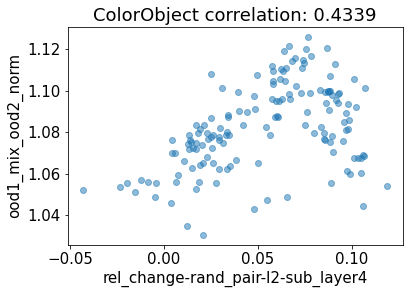

In [29]:
# scatter plot + correlation r
# 'rsa_obj_scene_layer4', 'prob3_acc_layer4', 'rel_change-rand_pair-l2-sub_layer4'
# 'fact_subspaces_fg_layer3', 'fact_subspaces_bg_layer3', 'inv_subspaces_fg_layer3', 'inv_subspaces_bg_layer3'
# 'fact_subspaces_fg_samples100_layer4'
name0 = 'rel_change-rand_pair-l2-sub_layer4' 

# ood1_mix_ood2_ori, ood1_mix_ood2_norm, test_ood1, test_ood2, 
# ood1_mix_ood2_percentile, test_ood1_percentile, test_ood2_percentile
name1 = 'ood1_mix_ood2_norm'

x_data, y_data = df_sub[name0].to_numpy(), df_sub[name1].to_numpy()
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel(name0)
plt.ylabel(name1)


plt.title(f"{args.dataset} correlation: %.4f" % (pearsonr(x_data, y_data)[0]))
plt.show()

In [123]:
# func for computing r2 with cv
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

def p_value(betas):
    # calculate p-value for two-sided difference from 0 test with a bootstrapped distribution of statistics, betas
    abs_mean_beta = np.abs(np.mean(betas))
    centered_betas = betas - np.mean(betas)
    outside_prop = np.mean(centered_betas < -abs_mean_beta) + np.mean(centered_betas > abs_mean_beta)
    return outside_prop

def calc_reg_r2(predictor_classes, predictand_class): # with bootstrap
    X = df_sub[predictor_classes].to_numpy()
    y = df_sub[predictand_class].to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)
    
    n_bootstrap = 10000
    bootstrap_coefs = np.zeros((n_bootstrap, X.shape[1]))
    bootstrap_scores = np.zeros(n_bootstrap)
    # Perform bootstrap resampling and fit linear regression model
    for i in tqdm(range(n_bootstrap)):
        # Generate bootstrap sample indices
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # score = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        bootstrap_scores[i] = r2
        bootstrap_coefs[i] = model.coef_
    
    # compute p-values
    p_values = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        betas = bootstrap_coefs[:, i]
        p_values[i] = p_value(betas)
    results = [bootstrap_scores, bootstrap_coefs, p_values]
    return results

In [131]:
# baselines
predictand_classes = ['ood1_mix_ood2_ori'] 
# 'ood1_mix_ood2_ori', 'ood1_mix_ood2_hmean', 'ood1_mix_ood2_percentile'
# 'test_ood1', 'test_ood2'

## using id_acc
predictor_classes = ['test_id']
r_sq = calc_reg_r2(predictor_classes, predictand_classes)
print(f"test_id: %.3f±%.3f" % (r_sq[0].mean(), r_sq[0].std()))

## using id_acc + algo
predictor_classes = ['test_id'] + [f'alg_{i}' for i in range(num_algo)]
r_sq = calc_reg_r2(predictor_classes, predictand_classes)
print(f"algo added: %.3f±%.3f" % (r_sq[0].mean(), r_sq[0].std()))

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1230.91it/s]


test_id: 0.024±0.155


100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1139.19it/s]

algo added: 0.019±0.254


In [133]:
# all fact metrics
layer_name_list = ['layer1', 'layer2', 'layer4']
all_fact_metrics = [f'rsa_cat_sep_{layer_name}' for layer_name in layer_name_list] + \
                [f'prob3_acc_{layer_name}' for layer_name in layer_name_list] + \
                [f'fact_subspaces_fg_samples10_{layer_name}' for layer_name in layer_name_list]

predictor_classes = all_fact_metrics + ['test_id'] + \
                    [f'alg_{i}' for i in range(num_algo)]

r_sq_fact = calc_reg_r2(predictor_classes, predictand_classes)
print(f"all fact added:\t %.3f±%.3f" % (r_sq_fact[0].mean(), r_sq_fact[0].std()))

# all weighted evidence metrics 
layer_name_list = ['layer1', 'layer2', 'layer4']
all_wt_evid_metrics =   [f'rel_change-rand_pair-l2-sub_{layer_name}' for layer_name in layer_name_list] + \
                        ['rel_change-rand_pair-kl-sub_output']

predictor_classes = all_wt_evid_metrics + ['test_id'] + \
                    [f'alg_{i}' for i in range(num_algo)]

r_sq_wt_evid = calc_reg_r2(predictor_classes, predictand_classes)
print(f"all wt_evid added:\t %.3f±%.3f" % (r_sq_wt_evid[0].mean(), r_sq_wt_evid[0].std()))

# all metrics
all_metrics = all_fact_metrics + all_wt_evid_metrics

predictor_classes = all_metrics + ['test_id'] + \
                    [f'alg_{i}' for i in range(num_algo)]

r_sq = calc_reg_r2(predictor_classes, predictand_classes)
print(f"all metrics added:\t %.3f±%.3f" % (r_sq[0].mean(), r_sq[0].std()))

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1022.16it/s]


all fact added:	 0.038±0.302


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1093.98it/s]


all wt_evid added:	 -0.040±0.289


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 975.74it/s]

all metrics added:	 -0.031±0.332


In [136]:
from scipy import stats
print(r_sq_wt_evid[0].mean(), r_sq[0].mean())
stats.ttest_ind(r_sq_wt_evid[0], r_sq[0])

-0.039554230068161965 -0.031154003632645897


Ttest_indResult(statistic=-1.9095749073675718, pvalue=0.05620226195675658)

In [ ]:
# read prob3
h5_file = h5py.File(os.path.join(args.data_dir, "prob3.h5py"), "r")
X_prob3 = h5_file.get('images')[()]
y_prob3_fg = h5_file.get('fg_classes')[()]
y_prob3_bg = h5_file.get('bg_classes')[()]
y_prob3 = np.zeros(y_prob3_fg.shape)
y_prob3[:1000] = y_prob3_fg[:1000]
y_prob3[1000:] = y_prob3_bg[1000:]+10
mask_size_prob3 = h5_file.get('mask_size')[()]
h5_file.close()

ref_matrix, ref_matrix_cat_specific, ref_matrix_co_occur = metrics.create_target_rdm(args.data_dir)

In [ ]:
# plot reference RDM
for ref_id, ref in enumerate([ref_matrix, ref_matrix_cat_specific, ref_matrix_co_occur]):
    plt.figure(figsize=(7.5,6))

    import matplotlib
    matplotlib.rcParams.update({'font.size': 15})
    plt.imshow(ref, cmap='coolwarm')
    plt.colorbar()
    plt.title("Reference RDM")
    plt.savefig(f"./fig/RDM_target_{ref_id}.png", format="png", dpi=500, bbox_inches = "tight")
    plt.show()

In [ ]:
## get model RDM
# get probe set
dataset = utils.SimpleDataset_masksize(X_prob3, y_prob3, mask_size_prob3)
data_loader_prob3 = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

# get model
args.algorithm = "ERM_augmentation"
_seed=0
_mix_rate=0.3
args.use_two_labels = True
args.use_mask = True
args.aug_fg = True
args.aug_bg = True
args.trial_seed = _seed
_exp_name = f"{args.bias}_ERM_augmentation_fgRandom_bgOnly_MixRate{_mix_rate}_seed{args.trial_seed}"
args.exp_name = _exp_name

eval_names = []
_, model = utils.init_data_model(args, eval_names)

# get model FEATS
FEATS = utils.get_feats(args, model, data_loader_prob3, ['layer3'], apply_pca=True)

In [ ]:
# get model RDM
X = FEATS['layer4'] 
num_samples = len(X)
data = rsatoolbox.data.Dataset(X.reshape(num_samples,-1))
rdms = rsatoolbox.rdm.calc_rdm(data)
rdm_matrices = rdms.get_matrices().squeeze()

plt.hist(rdm_matrices.reshape(-1))
plt.show()

In [ ]:
# clip + norm for better vis
upper_bound = 0.5
rdm_matrices[rdm_matrices>upper_bound] = upper_bound
rdm_matrices = rdm_matrices / rdm_matrices.max()

In [ ]:
# plot reference RDM
plt.figure(figsize=(7.5,6))

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.imshow(rdm_matrices, cmap='coolwarm')
plt.title("Model RDM")
plt.colorbar()
plt.savefig(f"./fig/RDM_model.png", format="png", dpi=500, bbox_inches = "tight")
plt.show()

In [ ]:
pearsonr(ref_matrix.reshape(-1), rdm_matrices.reshape(-1))

In [ ]:
dataset_name = 'test_ood1'
h5_cocoscene = h5py.File(f"../data/cocoplaces/{dataset_name}.h5py", "r")
cocoscene_imgs = h5_cocoscene['images']
cocoscene_fg_classes = h5_cocoscene['fg_classes']
cocoscene_fg_indexes = h5_cocoscene['fg_indexes']
cocoscene_bg_classes = h5_cocoscene['bg_classes']
cocoscene_bg_indexes = h5_cocoscene['bg_indexes']

In [ ]:
# create new dataset
fname = os.path.join(f"../data/cocoplaces/prob_dp_level_{dataset_name}.h5py")
if os.path.exists(fname): subprocess.call(['rm', fname])
h5_file = h5py.File(fname, mode='w')
h5_file.create_dataset('images', (2000,3,64,64), dtype=np.dtype('float32'))
h5_file.create_dataset('fg_classes', (2000,), dtype=np.dtype('int32'))
h5_file.create_dataset('bg_classes', (2000,), dtype=np.dtype('int32'))
h5_file.create_dataset('classes', (2000,), dtype=np.dtype('int32'))
num_imgs_pre_class = 100
place_img_index_start = 800
masks = coco_test_masks
imgs = coco_test_imgs

for class_index in tqdm(range(10)):
    for image_index in range(num_imgs_pre_class):
        _index = class_index*num_imgs_pre_class + image_index
        # get mask and img
        _mask = masks[_index]
        _coco_img = imgs[_index]
        # get place
        place_class_index = cocoscene_bg_classes[_index]
        place_img_index = cocoscene_bg_indexes[_index]
        _place_img = places_imges[place_class_index][place_img_index]

        # record fg 
        h5_file["images"][_index*2] = _coco_img * _mask
        h5_file["fg_classes"][_index*2] = class_index
        h5_file["bg_classes"][_index*2] = -1
        h5_file["classes"][_index*2] = class_index 
        # record bg 
        h5_file["images"][_index*2+1] = _place_img
        h5_file["fg_classes"][_index*2+1] = -1
        h5_file["bg_classes"][_index*2+1] = place_class_index
        h5_file["classes"][_index*2+1] = place_class_index + 10 
h5_file.close()

In [ ]:
h5_cocoscene.close()